\begin{align*}
    \text{Lecture Simulating the Physical World WS 19/20}
\end{align*}
\begin{align*}
    \text{Final Project by Joschka Birk}
\end{align*}

# Introduction

The Markov State Model is a stochastic model used to describe how a system ob well defined states 
changes with time. A system which can be described by this model, a so-called "Markovian" system 
has the property that the the probability of finding the system in a given state does not depend 
on the states it has visited before. In this sense, the system does not have a "memory" of what 
has happend before.

The dynamics of a Markovian system can be described using transition matrices. This transition matrix
can also be built for non-markovian systems, but it has specific properties if the system is indeed markovian.
This project demonstrates the construction of a simple two-state markovian state model and uses the 
properties of the corresponding transition matrix to validate that this system really is markovian.

# Implementation of Markovian Langevin Equation

The system used here is modelled by a double well potential $U(x)$ in one dimension $x$. So we look at a
single particle which can move along the x direction in the potential $U(x)$.

The movement of the particle is simulated using the "Markovian Langevin Equation", which results in the
numerical integration 

\begin{equation}
    x(t+\Delta t) = x(t) + v(t) \Delta t
\end{equation}

\begin{equation}
    v(t+\Delta t) = v(t) - \frac{1}{m} \frac{dU(x(t))}{dx} \Delta t - \frac{1}{m} \Gamma v(t) \Delta t +
                    \frac{1}{m} \sqrt{2k_BT \Gamma \Delta t} \, R(t)
\end{equation}

with $v(t)=\frac{dx}{dt}$ being the velocity, the potential $U(x)$, the friction $\Gamma$, the integration
timestep $\Delta t$ and normal distributed noise $R(t)$, which is a gaussian distributed noise term with
mean zero and variance one. The Boltzmann constant is denoted as $k_B$ and $T$ is the temperature. <br>
To simplify the calculations, the following unit conventions are used:

- $x$ has no units 

- $v(t)$ is given in $\text{ps}^{-1}$ 

- the mass $m$ (units $\text{ps}$) is set to $1 \text{ps}$ 

- energies are given in $\text{ps}^{-1}$, for $300 \,\text{K}$ we have $k_B T = 38 \,\text{ps}^{-1}$ 

- $\Gamma$ is given and used without any units 

- times (like $\Delta t$) are given in $\text{ps}$ 

- $R(t)$ has no units 

The potential is given by the double well potential

\begin{align}
    U(x) = k_BT \left( 0.28 \left(0.25 \,x^4 + 0.1 \,x^3 - 3.24\,x^2 \right) + 3.5 \right) \,.
\end{align}

The implementation of the potential as well as the numerical integration is shown below. The code contains
one class and several funtions which are briefly discussed in the following.

The potential $U(x)$ and it's first derivative $\frac{dU(x)}{dx}$ are implemented in the two functions
$\texttt{U(x)}$ and $\texttt{dUdx(x)}$. Both take the value x as input and return the corresponding value of
the potential or its derivative. <br>
The class $\texttt{Markov\_simulation}$ is used to perform the actual simulation of the dynamics. 
The initialisation of a corresponding object requires the number of simulation steps $\texttt{steps}$ as well as 
the chosen time step $\texttt{dt}$ which will be used for the simulation. The positions and velocities at each 
simulation step are stored in the attributes $\texttt{x}$ and $\texttt{v}$.
In order to perform a reproducable simulation, the seed of the $\texttt{numpy.random}$ module is set.
Afterwards the noise $R$ is generated using the $\texttt{numpy.random.normal()}$ function. <br>
The Langevin-integrator is implemented in the method $\texttt{Markov\_simulation.integrator()}$. It is a
straightforward integration of equations presented above. The method $\texttt{Markov\_simulation.simulate()}$
runs the simulation, which basically means that the integrator method is called $\texttt{steps}$ times. <br>
The method $\texttt{Markov\_simulation.save\_trajectory()}$ allows to save the positions of the whole simulation
in a text file. Furthermore, this method has the optional parameter $\texttt{interval}$ which allows to save
only every $n^{th}$ step of the simulation (if $\texttt{interval=n}$).

To be able to easily plot both the trajectory as a function of time and a histogram of the position $x$, two
plotting functions are implemented in the code. The first one, $\texttt{plot\_trajectory()}$,
plots the particles trajectory from a given starting step up to a final step. The second one, 
$\texttt{plot\_histogram()}$, takes the same values as the function for plotting the 
trajectory but instead puts these values in a normalised histogram to show the population of the different 
positions $x$.

In [1]:
import sys
sys.path.append("/Users/joschkabirk/Dropbox/Uni/SimPhys/Exercise_sheets/simphys")
from final_project import *
%config InlineBackend.figure_format = 'retina'

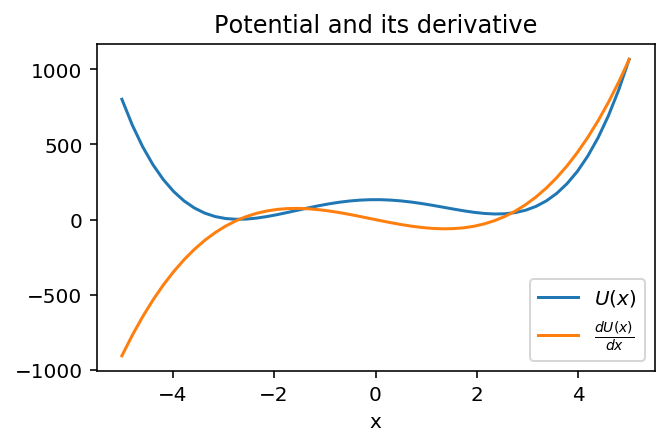

In [2]:
# plotting the Potential U(x) and the derivative dU/dx
x = np.linspace(-5,5)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title("Potential and its derivative")
ax.set_xlabel("x")
ax.plot(x, U(x), label=r"$U(x)$")
ax.plot(x, dUdx(x), label=r"$\frac{dU(x)}{dx}$")
ax.legend()
plt.show()

## Simulation

Using the code shown in the previous section, a simulation is carried out with the following parameters:

- $50 \cdot 10^6$ steps
- $\Delta t = 0.001 \,\text{ps}$ 
- $\Gamma = 100$ 
- $k_B T = 38 \,\text{ps}^-1$ 
- $x(0) = v(0) = 0$ 

The trajectory of the simulation is saved for the intervals $n=1,2,5,10,50,100,300,1000,2000,3000,4000$.

In [33]:
# constants and variables
n_steps = int(200e6)
delta_t = 0.001
seed_for_simulation = 5
lag_times = [1, 2, 5, 10, 50, 100, 300, 1000, 1500, 2000, 2500, 3000,
             3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500]

path = "/Users/joschkabirk/trajectories_simphys/seed%i_steps%1.e/"%(seed_for_simulation, n_steps)
print(path)

/Users/joschkabirk/trajectories_simphys/seed5_steps2e+08/


In [4]:
sim = Markov_simulation(steps=int(n_steps), dt=delta_t, seed=seed_for_simulation)
sim.simulate()

100%|██████████| 100000000/100000000 [09:38<00:00, 172975.07it/s]


In [34]:
# save the trajectories
for m in lag_times:
    # save in .npy format because this is much faster than saving as .csv or .txt
    sim.save_trajectory(path+"trajectory_with_interval_%i.npy"%(m), interval=m, printing=True)

file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again
file already exists -> not saved again


## Visualisation

The trajectory of the first $20 \cdot 10^5$ simulation steps is plotted below. As one can see, the trajectory always spends some time in either the left or the right minimium of the potential until it flips to the other one.

The second plot shows the histogram of the trajectory of the while simulation. The histogram agrees pretty well with the expected shape, since we have a lower minimum located at $x\approx -2.7$ and a slightly higher minimum at $x\approx 2.3$. Therefore, we expect a larger population in the left minimum compared to the right minimum.

In [35]:
traj1 = np.load(path+"trajectory_with_interval_1.npy")

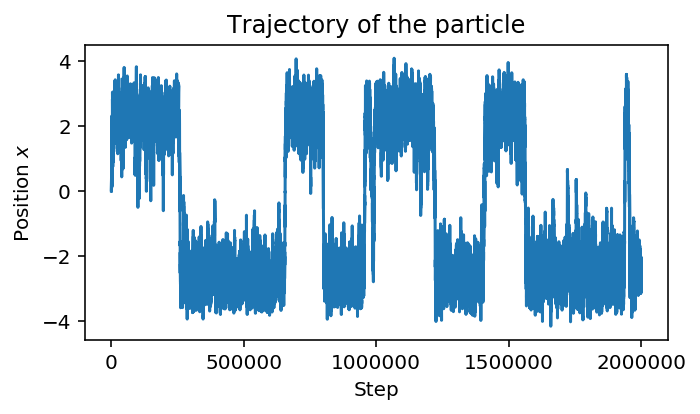

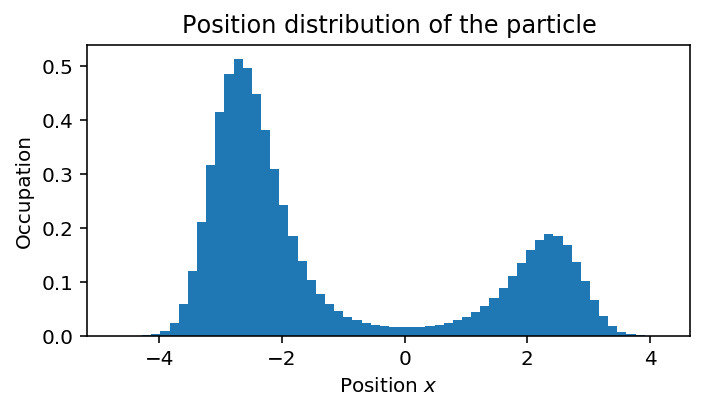

In [36]:
plot_trajectory(trajectory=traj1, end_step=int(20e5) )
plot_histogram(trajectory=traj1,  end_step=n_steps, nbins=60 )

# Calculation of Markov State Model

In order to generate a Markov State Model, two states are defined by separating the value range of $x$ into two "cores":

- core state "left" is reached for $x<-1$
- core state "right" is reached for $x>1$

The positions which lie between the core borders are always assigned to the previous state, i.e. if the particle is moving between $x=-1$ and $x=1$, but the last visited core state was "left", this state is still assigned to the "left" core until it crosses the border to the "right" core state. Since the simulation starts at $x=0$ but there is no previously visited state, the first state is randomly assigned to one of the two states. A schematic representation of these two core states is shown in the plot below.

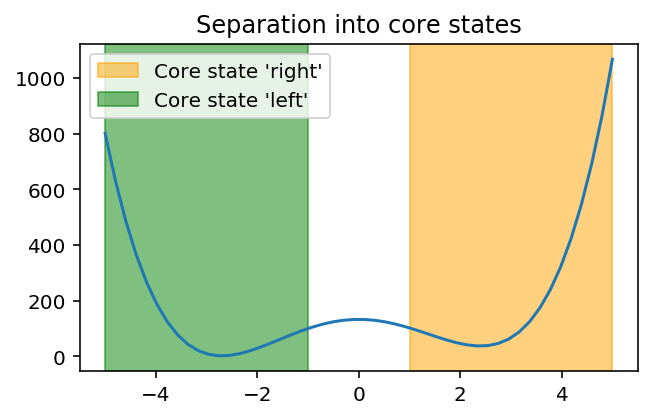

In [37]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x, U(x))
ax.set_title("Separation into core states")
ax.axvspan( 1, x.max(), alpha=0.5, color="orange", label="Core state 'right'")
ax.axvspan(-1, x.min(), alpha=0.5, color="g",      label="Core state 'left'")
ax.legend()
plt.show()

## Transition matrices

As mentioned in the introduction, transition matrices can be used to describe the dynamics of a Markov State Model.
For two states, which is the case in this demonstration, the transition matrix $\text{M}$ is a $2 \times 2$ matrix. The entries of $\text{M}$ are the following four probabilities:

- $p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)$ : probability of the transition "left"$\rightarrow$"right" 
- $p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right)$ : probability of remaining in "left"
- $p_{\text{right}\rightarrow\text{left}}\left(n\Delta t\right)$ : probability of the transition "right"$\rightarrow$"left" 
- $p_{\text{right}\rightarrow\text{right}}\left(n\Delta t\right)$ : probability of remaining in "right" 

These numbers depend on the so called "lag time" $n\Delta t$, which is the interval used when saving the trajectory of the simulation. The transition probability $p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)$ is given by the formula

\begin{align}
    p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right) = 
    \frac{N_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)}{N_\text{left}\left(n\Delta t\right)} \,,
\end{align}

where $N_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)$ is the number of transitions "left"$\rightarrow$"right" we see in the trajectory and $N_\text{left}\left(n\Delta t\right)$ is the total number of steps the system was in state "left". The so-called "self-transition" probability $p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right)$ is then simply given by

\begin{align}
    p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right) = 1 - p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right) \,.
\end{align}

The other two entries of M are calculated the same way by interchanging "left" and "right" in the indices.
The resulting transition matrix corresponding to a lag time of $n\Delta t$ is then given by

\begin{align}
    \text{M}\left(n\Delta t\right) = 
    \left( \begin{array}{rr}
               p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right)  & p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right) \\
               p_{\text{right}\rightarrow\text{left}}\left(n\Delta t\right)  & p_{\text{right}\rightarrow \text{right}}\left(n\Delta t\right) \\
\end{array}\right)  =
\left( \begin{array}{rr}
               p_{-1-1}\left(n\Delta t\right)  & p_{-11}\left(n\Delta t\right) \\
               p_{1-1}\left(n\Delta t\right)  & p_{11}\left(n\Delta t\right) \\
\end{array}\right) 
\,,
\end{align}

where for simplicity the state "left" is just called "-1" and the state "right" is called "1". This convention is used from now on in the rest of the report.

This matrix can be applied to a "statistical vector" $\left(a~~b\right)$, where $a$ is the probability that the system is in the state $-1$ and $b$ the probability for state $1$. Multiplying this state vector with $\text{M}$ yields the new statistical vector after the time $n\Delta t$.

\begin{align*}
    \left(a~~~b\right) \cdot\text{M}\left(n\Delta t\right) &= \left(a~~b\right) \cdot
                            \left( \begin{array}{rr}
                               p_{-1-1}\left(n\Delta t\right)  & p_{-11}\left(n\Delta t\right) \\
                               p_{1-1}\left(n\Delta t\right)  & p_{11}\left(n\Delta t\right) \\
                            \end{array}\right) \\\\
                       &= ( 
                           \underbrace{
                             a\cdot p_{-1-1}\left(n\Delta t\right)
                           + b\cdot p_{1-1}\left(n\Delta t\right)}_
                               {a\left(n\Delta t\right)}~~~
                            \underbrace{
                             a\cdot p_{-11}\left(n\Delta t\right)
                           + b\cdot p_{11}\left(n\Delta t\right)}_
                               {b\left(n\Delta t\right)}
                          ) \\ \\
                       &= \left(a\left(n\Delta t\right) ~~~ b\left(n\Delta t\right)\right)
\end{align*}

### Calculation of the transition matrices

In order to calculate the transition matrices for different lag times the trajectory is first translated into an array just consisting of the values $-1$ and $1$ corresponding to "left" and "right" for each step. Afterwards, corresponding probabilities are calculated. This is done with the function $\texttt{calculate\_states\_and\_M()}$ which is shown below. The function takes a trajectory as input, translated this trajectory into an array of states and then calculated the transition matrix. The returned elements are both the transition matrix and the states array.

In [38]:
# code calculate states

The transition matrix is calculated for all the lag times defined before, i.e. for each saved trajectory. The trajectories, the transition matrices and the state vectors are each stored in a dictionary with the lag time being the key of each item.

In [39]:
transition_matrices = {}
trajectories = {}
states = {}

for m in tqdm(lag_times):
    # load the saved trajectory
    trajectories.update({str(m) : np.load(path+"trajectory_with_interval_%i.npy"%(m))})
    # calculate the states-array and the corresponding transition matrix
    transition_matrix, states_array = calculate_states_and_M(trajectories[str(m)])
    # save them in the corresponding dictionaries
    transition_matrices.update({str(m) : transition_matrix})
    states.update({str(m) : states_array})

100%|██████████| 21/21 [00:31<00:00,  1.48s/it]


In [40]:
# plt.plot(trajectories["100"][:50000])
# plt.plot(states["100"][:50000])
# plt.show()

# Validation of Markov State Model

In order to be a valid MSM, the matrix $\text{M}(n\Delta t)$ must fulfill the condition 
\begin{equation}
    \text{M}(m \cdot n \Delta t) = \text{M}(n \Delta t)^m \,.
\end{equation}

This condition basically means that the probabilities for finding the system in either state $-1$ or $1$ after a time $m \,n\, \Delta t$ can be either calculated by applying "one large transition" with lag time $m \,n\, \Delta t$ or by applying $m$ times a transition of a short(er) lag time $n\, \Delta t$. This represents the idea of a system with no memory since the probabilities after a given time do not depend on what happend in between.

## Explicit verification 

The condition above can be checked explicitly by building the $m$-fold product of $\text{M}(n \Delta t)^m$ with itself and compare it with the corresponding matrix $\text{M}(m \cdot n \Delta t)$. Below this is done for

\begin{align}
    \text{M}(2 \cdot 1 \Delta t) &\overset{?}{=} \text{M}(1 \Delta t)^2, \\
    \text{M}(2 \cdot 2000 \Delta t) &\overset{?}{=} \text{M}(2000 \Delta t)^{2}, \\
    \text{M}(2000 \cdot 1 \Delta t) &\overset{?}{=} \text{M}(1 \Delta t)^{2000}, \\
    \text{M}(10\cdot 5 \Delta t) &\overset{?}{=} \text{M}(5 \Delta t)^{10}, \\
\end{align}

by printing the difference of the two matrices an the two sides of the equation.


In [41]:
print("M(Δt)^2 - M(2Δt) = ")
np.set_printoptions(precision=3)
print(np.linalg.matrix_power(transition_matrices["1"],2) \
      - transition_matrices["2"], "\n" , 30*"-")
print("M(1000Δt)^2 - M(2000Δt) = ")
print(np.linalg.matrix_power(transition_matrices["2000"],2) \
      - transition_matrices["4000"], "\n" , 30*"-")
print("M(Δt)^2000 - M(2000Δt) = ")
print(np.linalg.matrix_power(transition_matrices["1"],2000) \
      - transition_matrices["2000"], "\n", 30*"-")
print("M(5Δt)^10 - M(50Δt) = ")
print(np.linalg.matrix_power(transition_matrices["5"],10) \
      - transition_matrices["50"], "\n")

M(Δt)^2 - M(2Δt) = 
[[ 9.464e-11 -9.464e-11]
 [-2.406e-10  2.406e-10]] 
 ------------------------------
M(1000Δt)^2 - M(2000Δt) = 
[[-0.     0.   ]
 [ 0.001 -0.001]] 
 ------------------------------
M(Δt)^2000 - M(2000Δt) = 
[[-0.001  0.001]
 [ 0.004 -0.004]] 
 ------------------------------
M(5Δt)^10 - M(50Δt) = 
[[-5.527e-06  5.527e-06]
 [ 1.352e-05 -1.352e-05]] 



This test is actually quite hard, because all of these differences are quite close to zero. On first sight, one might also think, that the result for $n=1$ and $m=2$ (first printout) is much better than for $n=1000$ and $m=2$ (second printout) because the difference is much smaller in the first case even though both prinouts show the case of simply squaring the matrix. However, this can not be compared like that because the timescale represented by the two different cases differs by a factor of $2000$. A much more reasonable comparison would be the the second and the third printout as these two cases represent the same total timescale of $2000\Delta t$. In this comparison one can already see, that the condition needed for a valid MSM is fulfilled in the second printout rather than the third printout.

So one needs to compare for each fixed lag time $n_\text{fixed} \Delta t$ the different matrix products $\text{M}(n \Delta t)^m$ where $m = n_\text{fixed} / n$, i.e. one needs to compare all the different "ways" to obtain a transition corresponding to the lag time $n_\text{fixed} \Delta t$. 
If the system is Markovian, then all these different "ways" have to be the same, because then the probabilities do not change if the transition is carried out over many "short" transitions instead of one transition covering the whole lag time $n_\text{fixed} \Delta t$.

This comparison is done in the following using the function $\texttt{check\_MSM()}$. The code is not too long but can be quite confusing so it code is explained a little more detailed here.

The function produces one large plot containing 4 subplots that represent the four different matrix elements of the transition matrix. The $x$-axis shows the lag time in the form of $n_\text{fixed}$ and the $y$-axis shows the value of the entry in the transition matrix. The black curve shows the transition matrix that corresponds to a "direct" transition, i.e. $\text{M}(n_\text{fixed} \Delta t)$. For each lag time $n_\text{fixed} \Delta t$, there are several additional points drawn on the $y$-axis in different colours. These points represent the matrix entries of the diffent $m$-fold matrix products $\text{M}(n\Delta t)^m$ that lead to the same lag time , i.e. the exponent $m$ is always chosen in a way that $m \cdot n = n_\text{fixed}$. For example for the lag time corresponding to $n_\text{fixed} = 10$ there are three additional points in the plots which show the matrix elements of $\text{M}(1\Delta t)^{10}$, $\text{M}(2\Delta t)^5$ and $\text{M}(5\Delta t)^2$. For larger lag times there are many more possible products of transition matrices that correspond to that lag time so there are many more points in the graph.

The code loops over all lag times $\texttt{n\_fixed}$ that are considered in this example, then loops again over all lag times to find the lag times in the list that are shorter than $\texttt{n\_fixed}$ and if $\texttt{n\_fixed}$ can be written as the product of $n$ and some other integer $m$, the matrix entries of $\text{M}(n\Delta t)^m$ are stored in a numpy array. The rest of the code is just the plotting.

In [42]:
def check_MSM(lags):
    """ function to check for Markov criteria by comparing the matrix entries 
    for different lag times
    
    Parameters
    ----------
    lags : list of int
        list containing integer values. These lag times are then used 
        for the calculations
    """
    # array that stores the trajectory of M(n Δt)^m for all lag times
    matrix_trajectory = np.zeros([2, 2, len(lags), len(lags)])
    # array that contains the transition matrix M(n_fixed Δt) for all lag times n_fixed Δt
    reference_matrix = np.zeros([2,2, len(lags)])
    
    # loop over all lag times n_fixed Δt and store M(n_fixed Δt) as well as the 
    # corresponding matrix products M(n Δt)^m with m*n*Δt=n_fixed Δt
    for i in range(len(lags)):
        # loop over all other lag times and determine the required
        # factor/exponent m to get n*m = n_fixed
        n_fixed = lags[i]
        for j in range(len(lags)):
            n   = lags[j]
            if ((n_fixed > n) and (n_fixed%n == 0)):
                m = int(n_fixed / n)
                Mn_powered = np.linalg.matrix_power(transition_matrices[str(n)], m)
                matrix_trajectory[:,:, j, i] = Mn_powered
            else:
                # set nan so that it won't appear in the plot
                matrix_trajectory[:,:, j, i] = np.zeros([2,2]).fill(float('nan')) 
        
        reference_matrix[:,:, i] = transition_matrices[str(n_fixed)]
    
    fig, axs = plt.subplots(2, 2, figsize=(10,9))
    axs = axs.flatten()
    axs[0].set_ylabel(r"P(-1$\rightarrow$ -1)")
    axs[1].set_ylabel(r"P(-1$\rightarrow$ 1)")
    axs[2].set_ylabel(r"P(1$\rightarrow$ -1)")
    axs[3].set_ylabel(r"P(1$\rightarrow$ 1)")
    axs[0].set_xlabel(r"lag time $n_{fixed}$ ")
    axs[1].set_xlabel(r"lag time $n_{fixed}$ ")
    axs[2].set_xlabel(r"lag time $n_{fixed}$ ")
    axs[3].set_xlabel(r"lag time $n_{fixed}$ ")    
    
    cm = plt.get_cmap('nipy_spectral')
    # plot the reference matrix M(n_fixed Δt) = M(n_fixed Δt)
    axs[0].plot(lags, reference_matrix[0,0,:], label=r"M$(n_{fixed})$",\
                color=cm(-1), marker="+", markersize=10)
    axs[3].plot(lags, reference_matrix[1,1,:], color=cm(-1),\
                marker="+", markersize=10)
    axs[1].plot(lags, reference_matrix[0,1,:], color=cm(-1),\
                marker="+", markersize=10)
    axs[2].plot(lags, reference_matrix[1,0,:], color=cm(-1),\
                marker="+", markersize=10)
    
    # now loop over all n and plot the curve of M(n Δt)^m
    for i in range(0, len(lags), 1):
        # if the trajectory contains only nan, don't plot at all
        if np.isnan(matrix_trajectory[0,0,i,:]).all():
            continue
        c = cm(10+i*20)
        axs[0].plot(lags, matrix_trajectory[0,0,i,:], ls="--", \
                    marker="o", label="M$(%i \Delta t)^m$"%(lags[i]),
                    color=c)
        axs[3].plot(lags, matrix_trajectory[1,1,i,:], ls="--", \
                    marker="o", color=c)
        axs[1].plot(lags, matrix_trajectory[0,1,i,:], ls="--", \
                    marker="o", color=c)
        axs[2].plot(lags, matrix_trajectory[1,0,i,:], ls="--", \
                    marker="o", color=c)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88, wspace=0.3, hspace=0.25) 
    plt.show()

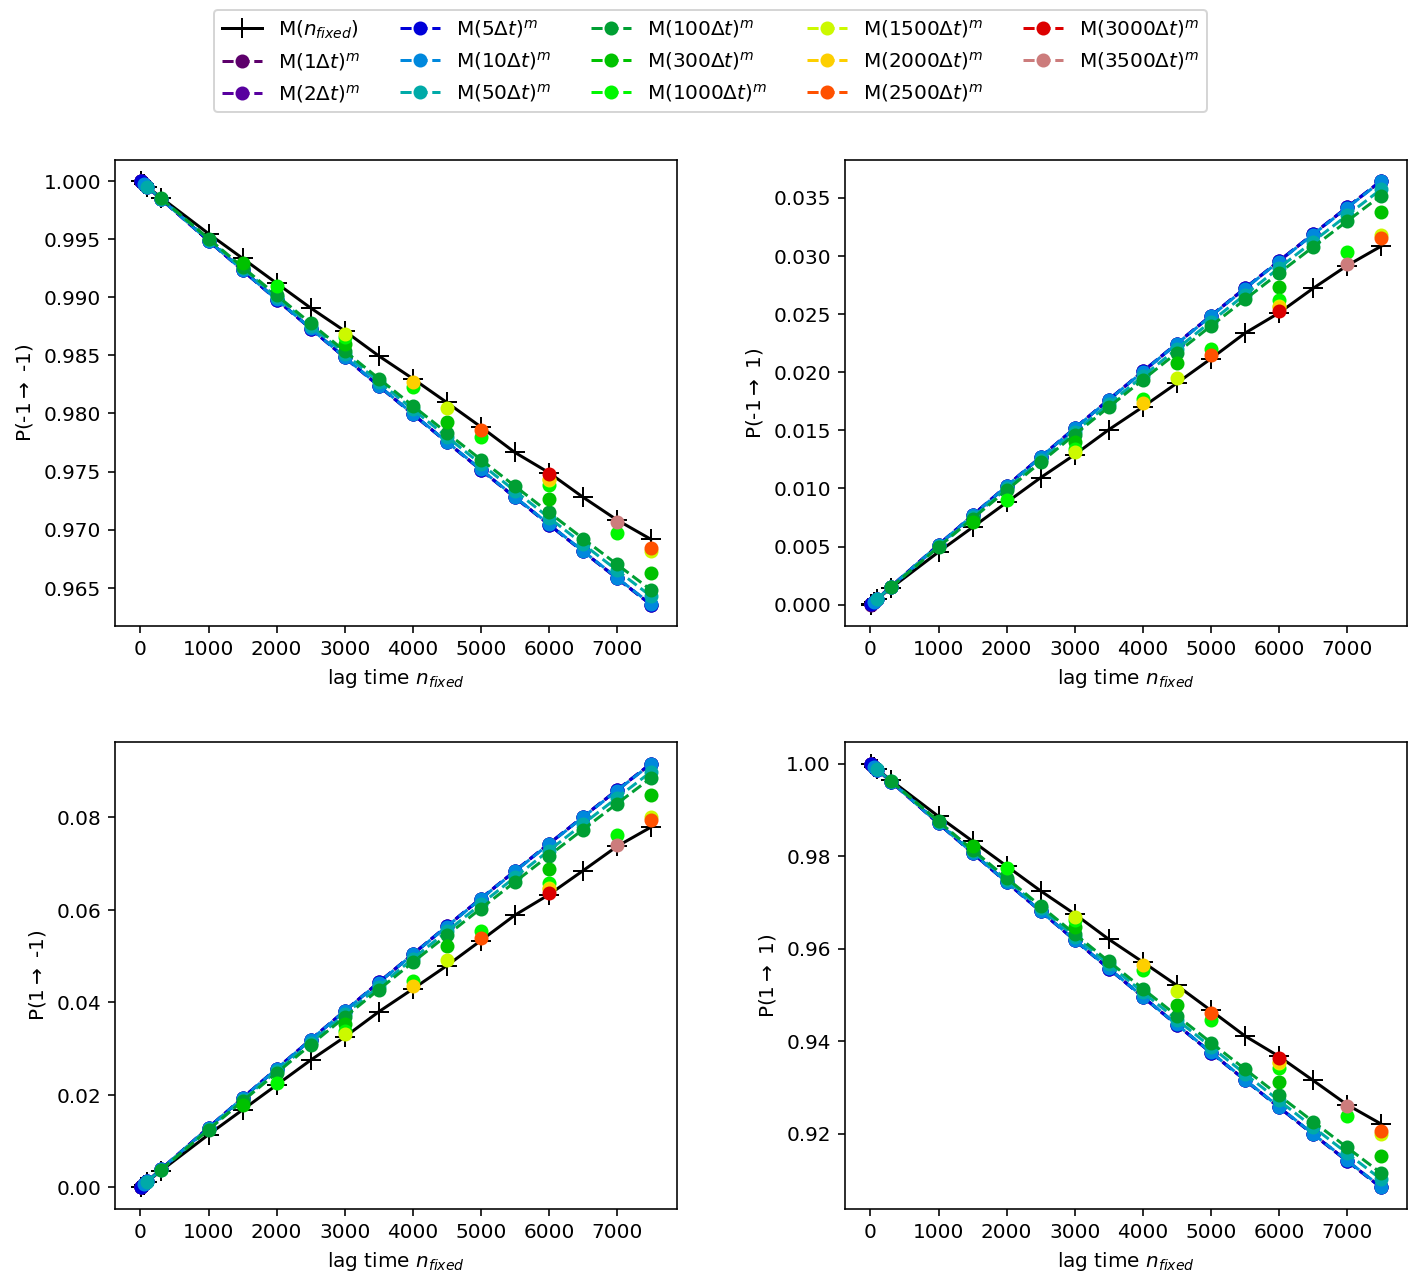

In [43]:
check_MSM(lag_times)

The plot of the different matrices makes it possible to estimate the minimal lag time $n_0$ to generate a valid MSM. To do that one has to look for the minimum $n$ (the n corresponding to one coloured line in the plots) for which the matrix element is agreeing with the black reference line even at long lag times. While the curves for $n < 1000$ are quite far away from the black reference curve, one can se quite some improvement in the light green lines. 

For $n=2000$ the points already agree quite well with the reference curve, although there can be seen a little bit more of a difference again at $n_\text{fixed}=8000$.
In general though, the coloured points get quite close to the reference curve for $n>2000$. As the coloured points agree quite well with the reference curve for $n\geq2500$, the minimal $n_0$ to generate a valid MSM is estimated to be $n_0=2500$.

## Validation of the Markov State Model using the implied timescale

Another much easier and robust way to validate a Markov State Model is the calculation of the so-called *implied timescale*. This method uses the properties of the transition matrix that show up when diagonalising it.

### Eigenvalues of transition matrices

A general transition matrix for a two state system can be simply written as 

\begin{align}
    \left( 
        \begin{array}{cc}
               \alpha  & 1-\alpha \\
               1-\beta  & \beta \\
        \end{array}
    \right)
\end{align}
with $\alpha, \beta \in [0, 1]$, which has the eigenvalues
\begin{align}
    \lambda_0 = 1 ~~~\text{and}~~~ \lambda_1= \alpha + \beta -1 \,.
\end{align}

Having again a look at the condition stated in the previous section
but now using the diagonalised matrices yields

\begin{align}
    \text{M}(m \cdot n \Delta t) = \text{M}(n \Delta t)^m
    ~~\Rightarrow~~
    \left( 
        \begin{array}{cc}
               \lambda_0(m \cdot n \Delta t)   & 0 \\
               0  & \lambda_1(m \cdot n \Delta t)  \\
        \end{array}
    \right) =
    \left( 
        \begin{array}{cc}
               \lambda_0(n \Delta t)^m   & 0 \\
               0  & \lambda_1(n \Delta t)^m  \\
        \end{array}
    \right) \,.
\end{align}

Since $\lambda_0 = 1$ for all lag times, this means that for a markovian process the eigenvalues $\lambda_1$ of different lag times fulfill

\begin{align}
    \lambda_1(m \cdot n \Delta t) = \lambda_1(n \Delta t)^m \,.
\end{align}

### Calculation and evaluation of the implied timescale

Using the properties of the eigenvalues of the transition matrix of a markovian system, one can validate a MSM much easier than done in the previous section. To do so, one calculates the *implied timescale*, which is defined as 

\begin{align}
    t(n \,\Delta t) = - \frac{n\,\Delta t}{\ln(\lambda_1(n\,\Delta t))} \,.
\end{align}

The implied timescale has the useful property that is is constant for valid MSM. This is easily shown by using the relation $\lambda_1(m \cdot n \Delta t) = \lambda_1(n \Delta t)^m$, which leads to

\begin{align}
    t(m \cdot n \,\Delta t) = - \frac{m\cdot n\,\Delta t}{\ln(\lambda_1(m \cdot n\,\Delta t))} =
    - \frac{m\cdot n\,\Delta t}{\ln\left(\lambda_1(n\,\Delta t)^m\right)} = 
    - \frac{m\cdot n\,\Delta t}{m \cdot \ln\left(\lambda_1(n\,\Delta t)\right)} =
    t(n \,\Delta t) \,.
\end{align}

So in order to check for the minimal $n_0$ to generate a valid MSM, one can just calculate the implied timescale as a function of the lagtime and estimate $n_0$ by looking for which lagtime the implied timescale becomes constant.

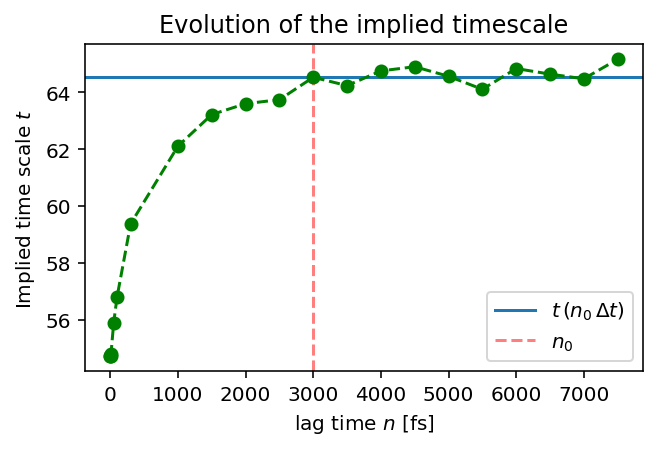

In [46]:
t_values = []
lambdas = {}

for n in lag_times:
    # diagonalise the transition matrix and get the smaller eigenvalue
    eig_vals, eig_vecs = np.linalg.eig(transition_matrices[str(n)])
    lambda_1 = eig_vals.min()
    # calculate and save the implied timescale and the eigenvalue
    t = - n*delta_t / np.log(lambda_1)
    t_values.append(t)
    lambdas.update({str(n) : lambda_1})

# plot the result
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title("Evolution of the implied timescale")
ax.set_xlabel(r"lag time $n$ [fs]")
ax.set_ylabel(r"Implied time scale $t$")
n_0 = 3000
ax.axhline(-delta_t * n_0 / np.log(lambdas[str(n_0)]), label=r"$t\,(n_0 \,\Delta t)$")
ax.axvline(n_0, ls="--", color="r", label=r"$n_0$", alpha=0.5)
plt.plot(lag_times, t_values, ls="--", marker="o", color="g")
ax.legend()
plt.show()

The results for the example calculated here are shown in the plot below. As one can see, the implied timescale $t$ becomes quite constant for lag times $n \geq3000$. This $n_0 = 3000$ is slightly larger than the value estimated with the explicit comparison of the matrix elements.

There are also still some fluctuations in the implied timescale for $n>n_0$ but since these values are all located around the implied timescale obtained at $n = 3000$ so this seems to be a good estimate.

# Summary

This project demonstrated the construction and validation of a Markov State Model. By using a simple double well potential and the Markovian Langevin Equation, a simulation was carried out in order to simulate the trajectory of a $1$ dimensional particle moving in this potential. By defining two core states along the position value range, the transition matrix of the system was calculated for a variety of different lag times. These transition matrices were then used to analyse at which lag time the system becomes a valid Markov State Model.

This estimation was performed in two different ways. First, the estimation was done by explicity comparing the matrix entries of different matrix products corresponding to the same lag time. However, this method is not as easy to visualise and not as robust as the second method used here, which exploits the properties of the transition matrix under diagonalisation. Due to the relation between the eigenvalues of transition matrices corresponding to different lag times, the implied timescale of a system becomes constant for a MSM. Hence, by calculating the implied timescale of the system at different lag times, the minimal lag time for a MSM could be estimated much easier.